K-Means Clustering for TESS Features

Cluster to Variable_Type mapping:
{0: 'EA', 1: 'SR', 2: 'RRAB'}


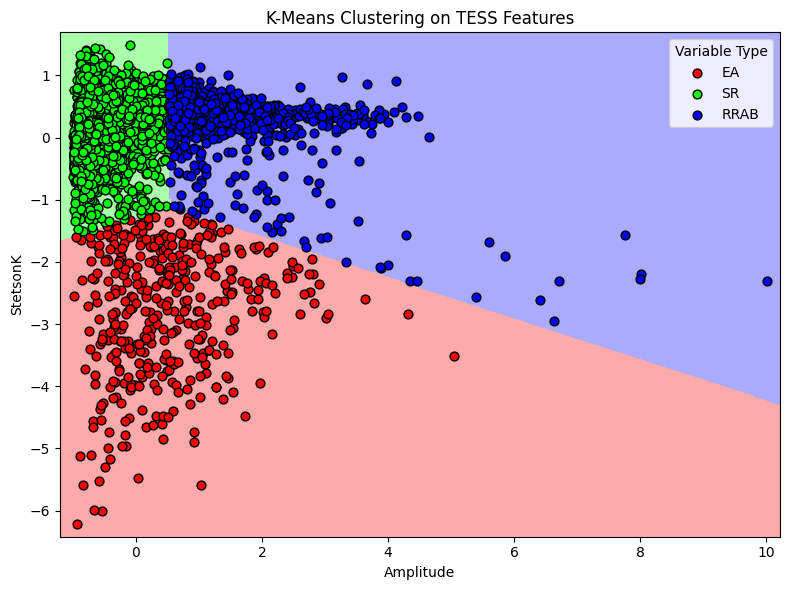

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Load features including Variable_Type
df = pd.read_csv("/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_outliercleaned.csv")

x_feature = "Amplitude"
y_feature = "StetsonK"

# Drop rows with missing values in relevant columns
df_clean = df[[x_feature, y_feature, "Variable_Type"]].dropna()

# Prepare data
X = df_clean[[x_feature, y_feature]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels to dataframe
df_clean["cluster"] = labels

# Find the most common Variable_Type in each cluster
cluster_names = df_clean.groupby("cluster")["Variable_Type"] \
    .agg(lambda x: x.value_counts().index[0]) \
    .to_dict()

print("Cluster to Variable_Type mapping:")
print(cluster_names)

# Create mesh for decision boundary
x_min, x_max = X_scaled[:, 0].min() - 0.2, X_scaled[:, 0].max() + 0.2
y_min, y_max = X_scaled[:, 1].min() - 0.2, X_scaled[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

# Plot decision boundaries
plt.figure(figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

# Scatter plot with meaningful labels
for cluster_id, color in zip(cluster_names.keys(), ['#FF0000', '#00FF00', '#0000FF']):
    cluster_label = cluster_names[cluster_id]
    plt.scatter(X_scaled[df_clean["cluster"] == cluster_id, 0],
                X_scaled[df_clean["cluster"] == cluster_id, 1],
                c=color,
                edgecolor='k',
                s=40,
                label=cluster_label)

plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title("K-Means Clustering on TESS Features")
plt.legend(title="Variable Type")
plt.tight_layout()

plt.savefig("/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_kmeans_features_labeled.pdf")
plt.show()


Confusion matrix

/home/devika/anaconda3/envs/env_ISLP/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


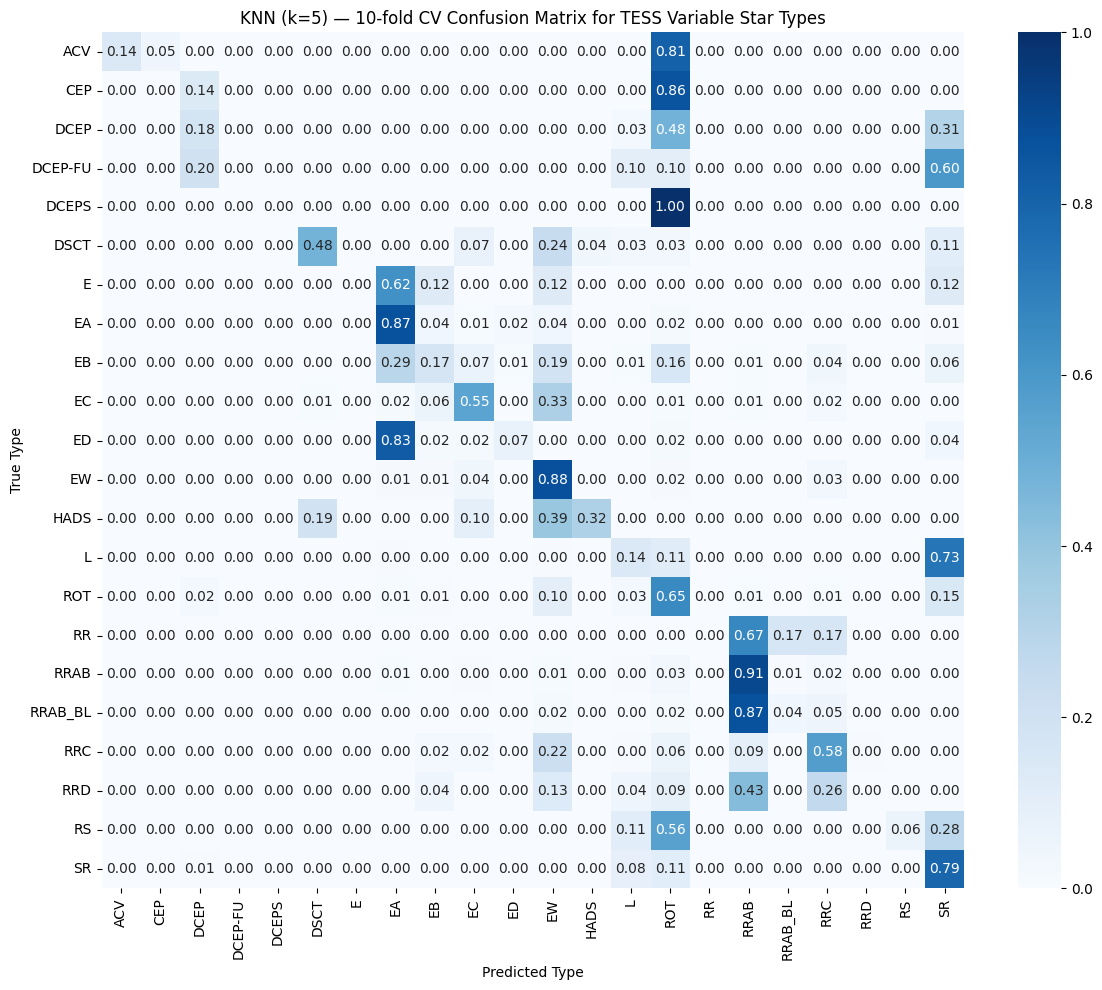

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

# ---- Utility functions you provided ----

def to_density(cf):
    density = []
    n, k = cf.shape
    for i in range(n):
        density_row = []
        total_stars = sum(cf[i])
        for j in range(k):
            density_row.append(cf[i][j] / total_stars if total_stars > 0 else 0)
        density.append(density_row)
    return np.array(density)


def make_confusion_matrix(cf_,
                          xlabel, ylabel,
                          group_names=None,
                          categories='auto',
                          count=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    
    cf = to_density(cf_)

    blanks = ['' for _ in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels, group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    if figsize is None:
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        categories = False

    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, yticklabels=categories, xticklabels=categories)

    if xyplotlabels:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    if title:
        plt.title(title)

# ---- Load your TESS features ----

df = pd.read_csv("/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_outliercleaned.csv")

# Drop identifier columns that are not features
X = df.drop(columns=['Variable_Type', 'Filename', 'Star_ID']).values
y = df['Variable_Type'].values

# Class labels
class_names = np.unique(y)

# ---- 10-fold Stratified KNN ----

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

conf_matrix_sum = np.zeros((len(class_names), len(class_names)), dtype=int)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    conf_matrix_sum += cm

# ---- Plot final confusion matrix ----

make_confusion_matrix(
    conf_matrix_sum,
    xlabel='Predicted Type',
    ylabel='True Type',
    categories=class_names,
    count=True,
    figsize=(12, 10),
    cmap='Blues',
    title='KNN (k=5) — 10-fold CV Confusion Matrix for TESS Variable Star Types'
)

plt.tight_layout()
# Save as PDF
plt.savefig("/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_Confusion_Matrix_outliercleaned.pdf")
plt.show()


NaN count before imputation: 2194
Inf count before replacement: 0


/home/devika/anaconda3/envs/env_ISLP/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


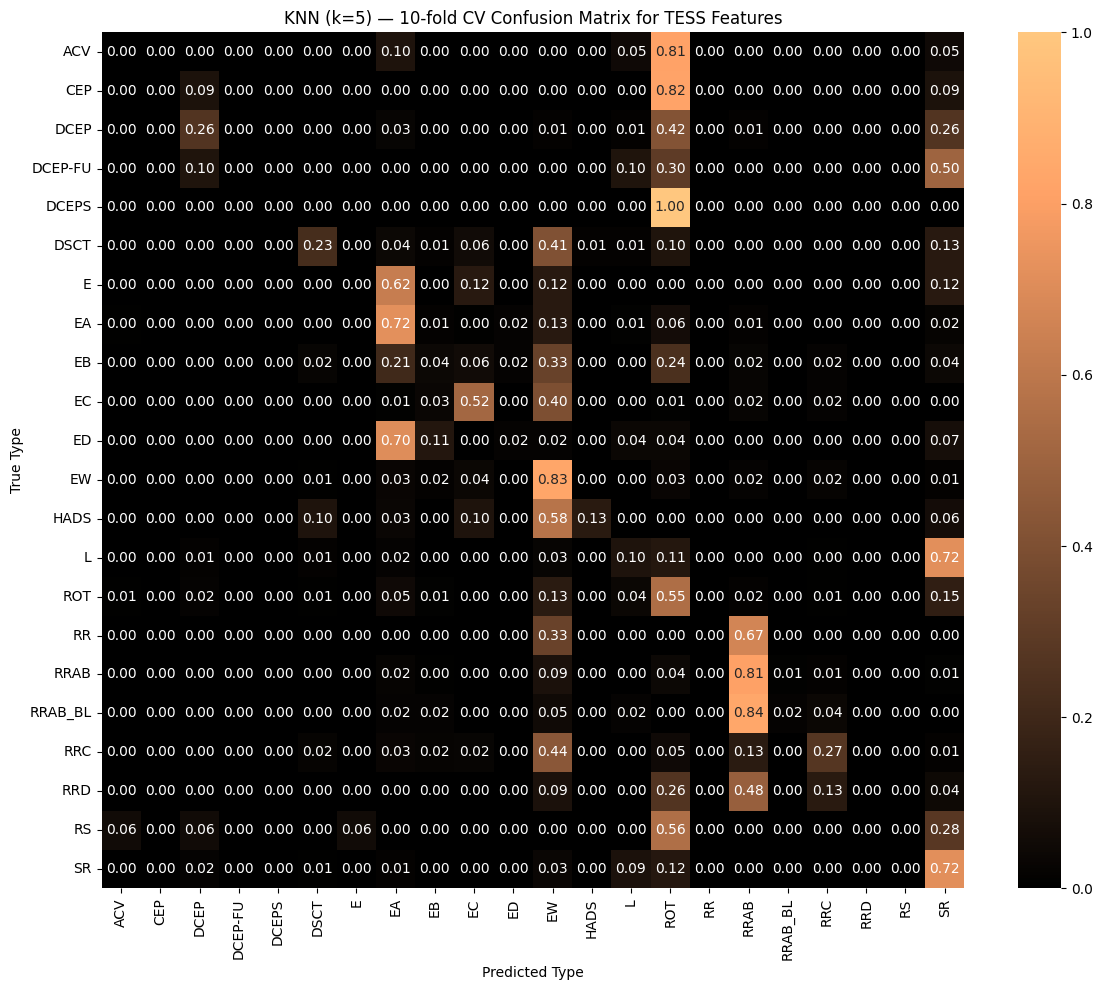

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer

# ---------- Utility Functions ----------

def to_density(cf):
    density = []
    n, k = cf.shape
    for i in range(n):
        total = np.sum(cf[i])
        row = [(cf[i][j] / total if total > 0 else 0) for j in range(k)]
        density.append(row)
    return np.array(density)

def make_confusion_matrix(cf_,
                          xlabel, ylabel,
                          group_names=None,
                          categories='auto',
                          count=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          save_path=None):

    cf = to_density(cf_)
    blanks = ['' for _ in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels, group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    if figsize is None:
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        categories = False

    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar,
                xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    if title:
        plt.title(title)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf')
    plt.show()

# ---------- Load and Preprocess Data ----------

df = pd.read_csv("/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_raw.csv")  # ⬅️ Replace with actual path

# Extract features and labels
X_raw = df.drop(columns=['Variable_Type', 'Filename', 'Star_ID'])
y = df['Variable_Type'].values

# Replace inf/-inf with NaN
X_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optional: Check how many issues we have
print("NaN count before imputation:", X_raw.isna().sum().sum())
print("Inf count before replacement:", np.isinf(X_raw.values).sum())

# Impute missing values with column means
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X_raw)

# Class labels
class_names = np.unique(y)

# ---------- 10-fold Cross-Validation with KNN ----------

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

conf_matrix_sum = np.zeros((len(class_names), len(class_names)), dtype=int)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    conf_matrix_sum += cm

# ---------- Plot and Save the Final Confusion Matrix ----------

make_confusion_matrix(
    conf_matrix_sum,
    xlabel='Predicted Type',
    ylabel='True Type',
    categories=class_names,
    count=True,
    figsize=(12, 10),
    cmap='copper',  # changed to brownish
    title='KNN (k=5) — 10-fold CV Confusion Matrix for TESS Features',
    save_path="/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_Confusion_Matrix_raw.pdf"
)


NaN count before imputation: 0
Inf count before replacement (should be 0 now): 0


/home/devika/anaconda3/envs/env_ISLP/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


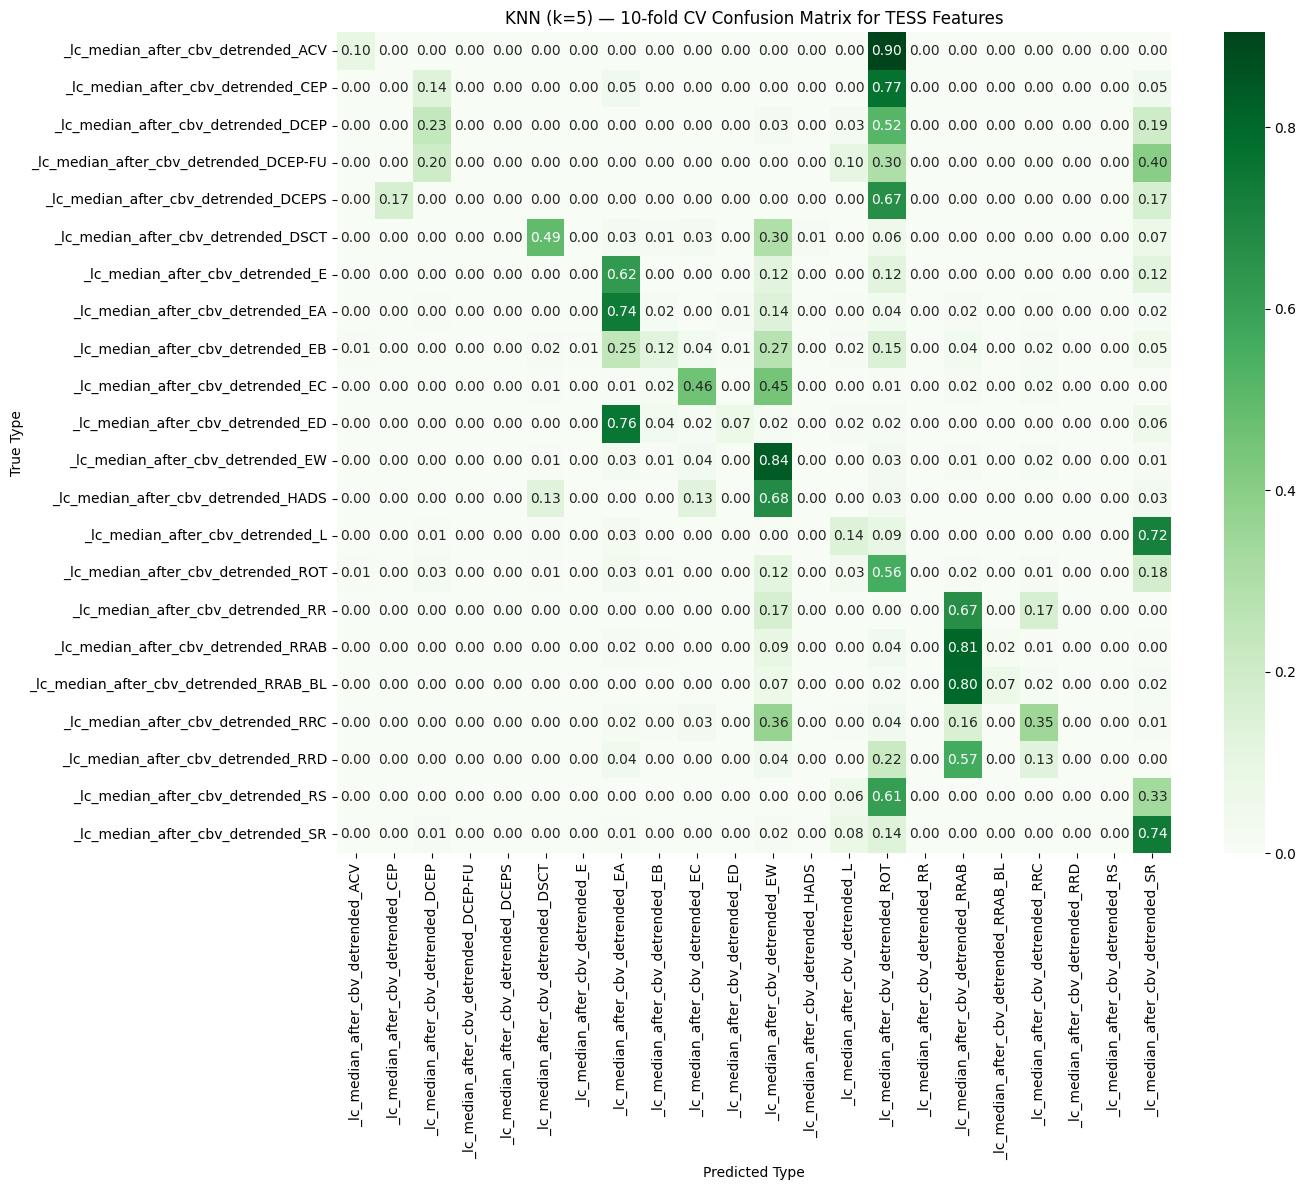

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer

# ---------- Utility Functions ----------

def to_density(cf):
    density = []
    n, k = cf.shape
    for i in range(n):
        total = np.sum(cf[i])
        row = [(cf[i][j] / total if total > 0 else 0) for j in range(k)]
        density.append(row)
    return np.array(density)

def make_confusion_matrix(cf_,
                          xlabel, ylabel,
                          group_names=None,
                          categories='auto',
                          count=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          save_path=None):

    cf = to_density(cf_)
    blanks = ['' for _ in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels, group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    if figsize is None:
        figsize = plt.rcParams.get('figure.figsize')

    if not xyticks:
        categories = False

    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar,
                xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)

    if title:
        plt.title(title)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='pdf')
    plt.show()

# ---------- Load and Preprocess Data ----------

cols_to_use = [
    'Amplitude','Rcs','StetsonK','Meanvariance','Autocor_length','Con','Beyond1Std','SmallKurtosis','Std','Skew',
    'MaxSlope','MedianAbsDev','MedianBRP','PairSlopeTrend','FluxPercentileRatioMid20','FluxPercentileRatioMid35',
    'FluxPercentileRatioMid50','FluxPercentileRatioMid65','FluxPercentileRatioMid80','PercentDifferenceFluxPercentile',
    'PercentAmplitude','LinearTrend','Eta_e','Mean','Q31','AndersonDarling','Gskew','StructureFunction_index_21',
    'StructureFunction_index_31','StructureFunction_index_32','Pvar','ExcessVar'
]

# Load Data
file_path = "/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_median_after_detrended.csv"
df = pd.read_csv(file_path)

# Extract features and labels
X_raw = df[cols_to_use].astype(np.float64)
y = df['Variable_Type'].values

# Replace inf/-inf with NaN
X_raw.replace([np.inf, -np.inf], np.nan, inplace=True)

# Report before imputation
print("NaN count before imputation:", X_raw.isna().sum().sum())
print("Inf count before replacement (should be 0 now):", np.isinf(X_raw.values).sum())

# Impute missing values with column mean
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X_raw)

# Check for any remaining invalid entries
if np.isnan(X).any():
    print("Warning: Still NaNs present after imputation.")
if np.isinf(X).any():
    print("Warning: Still inf values present after preprocessing.")

# Class labels
class_names = np.unique(y)

# ---------- 10-fold Cross-Validation with KNN ----------

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

conf_matrix_sum = np.zeros((len(class_names), len(class_names)), dtype=int)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=class_names)
    conf_matrix_sum += cm

# ---------- Plot and Save the Final Confusion Matrix ----------

# make_confusion_matrix(
#     conf_matrix_sum,
#     xlabel='Predicted Type',
#     ylabel='True Type',
#     categories=class_names,
#     count=True,
#     figsize=(14, 12),
#     cmap='Blues',
#     title='KNN (k=5) — 10-fold CV Confusion Matrix for TESS Features_median_after_detrended',
#     save_path="knn_tess_confusion_matrix__median_after_detrended.pdf"
# )
make_confusion_matrix(
    conf_matrix_sum,
    xlabel='Predicted Type',
    ylabel='True Type',
    categories=class_names,
    count=True,
    figsize=(14, 12),
    cmap='Greens',  # changed to brownish
    title='KNN (k=5) — 10-fold CV Confusion Matrix for TESS Features',
    save_path="/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_Confusion_Matrix_median_after_detrended.pdf"
)


Code evaluates K-Means clustering on three different TESS light curve feature datasets (raw, median after detrended, and outlier cleaned), using 10-fold stratified cross-validation.

Processing raw dataset...


/home/devika/anaconda3/envs/env_ISLP/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  warnings.warn(


Saved: confusion_matrix_raw.pdf
Processing median_after_detrended dataset...


/home/devika/anaconda3/envs/env_ISLP/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Saved: confusion_matrix_median_after_detrended.pdf
Processing outliercleaned dataset...


/home/devika/anaconda3/envs/env_ISLP/lib/python3.11/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Saved: confusion_matrix_outliercleaned.pdf


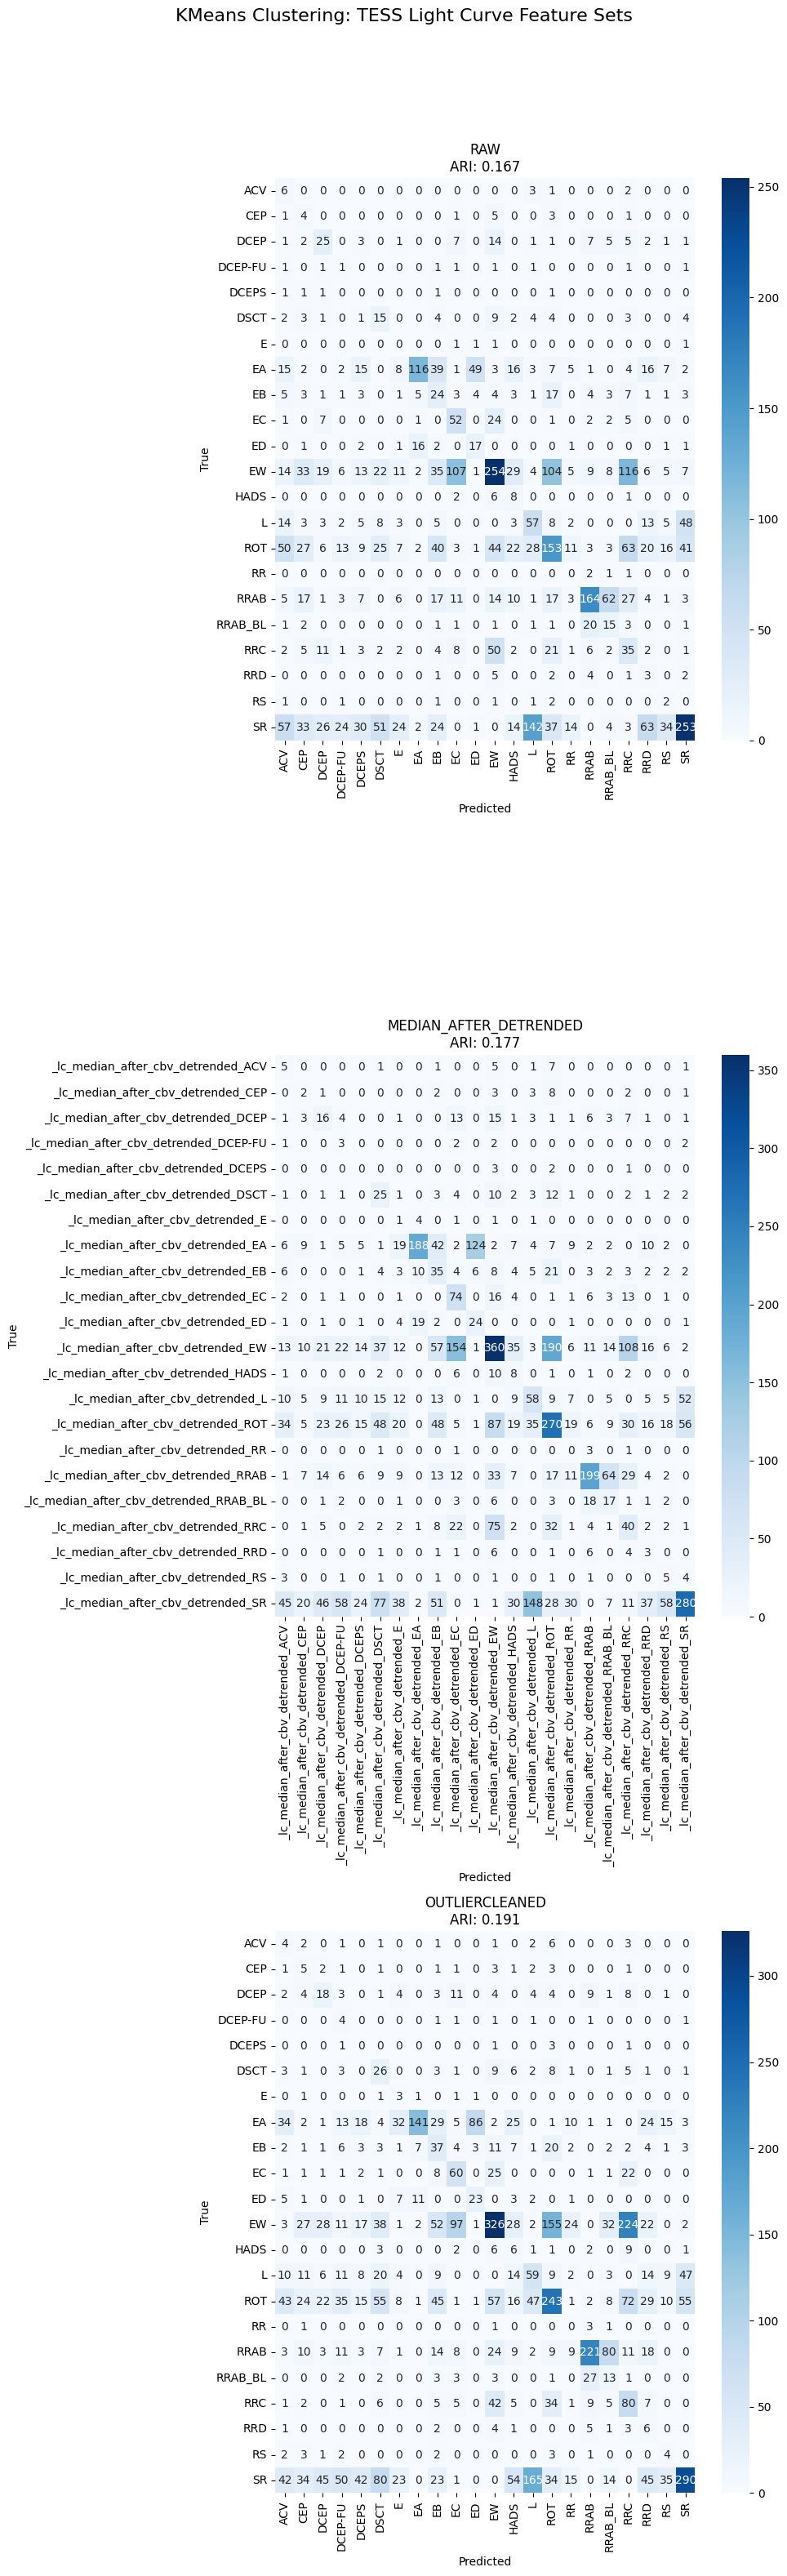

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Paths to your feature CSV files
datasets = {
    "raw": "/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_raw.csv",
    "median_after_detrended": "/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_median_after_detrended.csv",
    "outliercleaned": "/home/devika/PhD/S1/Astroinformatics/Project/Results/TESS_features_outliercleaned.csv"
}

# Function to run KMeans with 10-fold CV and return confusion matrix + ARI
def evaluate_kmeans(file_path, label_col="Variable_Type"):
    df = pd.read_csv(file_path).dropna()
    X = df.drop(columns=[label_col, "Filename", "Star_ID"], errors="ignore").values
    y = df[label_col].values

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    n_classes = len(le.classes_)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    total_cm = np.zeros((n_classes, n_classes), dtype=int)
    ari_scores = []

    for fold, (_, test_index) in enumerate(skf.split(X_scaled, y_encoded)):
        X_test, y_test = X_scaled[test_index], y_encoded[test_index]
        kmeans = KMeans(n_clusters=n_classes, random_state=fold)
        y_pred = kmeans.fit_predict(X_test)

        # Align clusters using Hungarian algorithm
        cm = confusion_matrix(y_test, y_pred)
        row_ind, col_ind = linear_sum_assignment(-cm)
        aligned_pred = np.zeros_like(y_pred)
        for i, j in zip(col_ind, row_ind):
            aligned_pred[y_pred == i] = j

        total_cm += confusion_matrix(y_test, aligned_pred, labels=np.arange(n_classes))
        ari_scores.append(adjusted_rand_score(y_test, aligned_pred))

    return total_cm, np.mean(ari_scores), le.classes_

# === Run evaluations for each dataset variant ===
results = {}
for label, path in datasets.items():
    print(f"Processing {label} dataset...")
    cm, ari, classes = evaluate_kmeans(path)
    results[label] = {"cm": cm, "ari": ari, "classes": classes}

    # Save each confusion matrix to PDF
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.title(f"KMeans Confusion Matrix - {label.upper()} (ARI: {ari:.3f})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    pdf_filename = f"confusion_matrix_{label}.pdf"
    plt.savefig(pdf_filename)
    print(f"Saved: {pdf_filename}")
    plt.close()

# Display confusion matrices one below the other
fig, axes = plt.subplots(3, 1, figsize=(10, 30))  # 3 rows, 1 column, taller figure

for ax, (label, res) in zip(axes, results.items()):
    sns.heatmap(res["cm"], annot=True, fmt="d", cmap="Blues", 
                xticklabels=res["classes"], yticklabels=res["classes"], ax=ax)
    ax.set_title(f"{label.upper()}\nARI: {res['ari']:.3f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.suptitle("KMeans Clustering: TESS Light Curve Feature Sets", fontsize=16, y=1.05)
plt.show()
